# XTB Analysis

In [5]:
from pathlib import Path
from processing_utils import pairwise_distance, xyz_to_np
from matplotlib import pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import os

In [6]:
xtb_path = Path("BO/optimizations_forces_wider_complete/")
DFT_path = Path("DFT/experiments_forces/")
reference_path = Path("uniques_100_molecules_42_seed/")

In [7]:
# for molecule in DFT_path.iterdir():
#     if molecule.is_dir():
#         base_xtb_xyz = molecule / "base" / "xtb" / "xtbopt.xyz"
#         optimized_xtb_xyz = molecule / "optimized" / "xtb" / "xtbopt.xyz"
#         reference_xtb_xyz = reference_path / f"{molecule.name}.xyz"

#         base_xtb_np, atoms, _ = xyz_to_np(base_xtb_xyz)
#         optimized_xtb_np = xyz_to_np(optimized_xtb_xyz)[0]
#         reference_xtb_np = xyz_to_np(reference_xtb_xyz)[0]

#         base_diff = abs(
#             pairwise_distance(base_xtb_np) - pairwise_distance(reference_xtb_np)
#         )
#         optimized_diff = abs(
#             pairwise_distance(optimized_xtb_np) - pairwise_distance(reference_xtb_np)
#         )

#         improvement = base_diff - optimized_diff

#         plt.figure()

#         ax = sns.heatmap(
#             improvement,
#             annot=True,
#             fmt=".2f",
#             cmap="coolwarm",
#             cbar_kws={"label": "Improvement in Pairwise Distances"},
#             xticklabels=atoms,
#             yticklabels=atoms,
#             center=0,
#         )

#         ax.xaxis.tick_top()

#         plt.title(f"Improvement in Pairwise Distances for {molecule.name}")
#         os.makedirs("processing/xtb_analysis/results", exist_ok=True)

#         plt.savefig(
#             f"processing/xtb_analysis/results/{molecule.name}.png",
#             bbox_inches="tight",
#         )
#         plt.close()

## Optimized Parameter Distributions

In [8]:
optimized_params = defaultdict(list)
for molecule in xtb_path.iterdir():
    if molecule.is_dir():
        with open(molecule / "BO_results.json", "r") as f:
            bo_results = json.load(f)
        params = bo_results["best_params"]

        for param, value in params.items():
            optimized_params[param].append(value)

base_parameter_values = {
    "ksd": 2.0,
    "kpd": 2.0,
    "kp": 2.23,
    "ks": 1.85,
    "kexp": 1.5,
}

xlims = {
    "ksd": (0.6, 3.4),
    "kpd": (0.6, 3.4),
    "kp": (0.669, 3.791),
    "ks": (0.555, 3.145),
    "kexp": (0.45, 2.55),
}

for param, values in optimized_params.items():
    plt.figure()
    sns.histplot(values)
    plt.axvline(
        base_parameter_values[param], color="red", linestyle="--", label="Base Value"
    )
    plt.title(f"Distribution of {param} across Molecules")
    plt.xlabel(param)
    plt.ylabel("Frequency")
    plt.xlim(xlims[param])
    # plt.axvline(xlims[param][0], color="black", linestyle="--", label="Min Limit")
    # plt.axvline(xlims[param][1], color="black", linestyle="--", label="Max Limit")
    plt.legend()
    os.makedirs("processing/xtb_analysis/params", exist_ok=True)
    plt.savefig(f"processing/xtb_analysis/params/{param}.svg", bbox_inches="tight")
    plt.close()

## Determining Number of Iterations

In [33]:
xtb_path = Path("BO/")
reference_path = Path("BO/optimizations_forces_wider_complete")

In [34]:
results = {}
reference_results = {}

for molecule in reference_path.iterdir():
    if molecule.is_dir():
        with open(molecule / "BO_results.json", "r") as f:
            bo_results = json.load(f)
        reference_results[molecule.name] = bo_results["best_value"]

for optimization_steps in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]:
    cur_path = xtb_path / f"optimizations_forces_wider_{optimization_steps}/"
    cur_steps_score = 0
    for molecule in cur_path.iterdir():
        if molecule.is_dir():
            with open(molecule / "BO_results.json", "r") as f:
                bo_results = json.load(f)
            # if bo_results['best_value'] > reference_results[molecule.name]:
            #     cur_steps_score += 1
            cur_steps_score += bo_results["best_value"] - reference_results[molecule.name]
    results[optimization_steps] = cur_steps_score

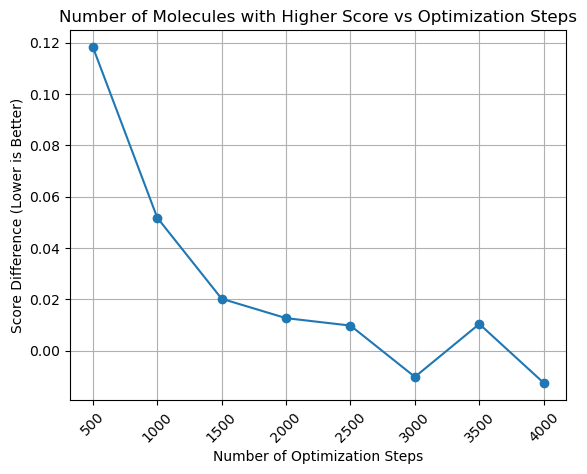

In [35]:
plt.figure()
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title("Number of Molecules with Higher Score vs Optimization Steps")
plt.xlabel("Number of Optimization Steps")
plt.ylabel("Score Difference (Lower is Better)")
plt.grid()
plt.xticks(list(results.keys()), rotation=45)
plt.savefig("report/optimization_steps_vs_score.svg", bbox_inches="tight")